# Analysis on FAO Agricultural Production Data (1961–2023)

This notebook presents a global analysis of agricultural production based on the official datasets from the Food and Agriculture Organization (FAO) of the United Nations.  
The aim is to understand how agricultural production has evolved across the world from **1961 to 2023**, identify the leading producer countries, and analyze structural changes over time.

## Objectives
- Track the global evolution of agricultural production volumes.  
- Identify historical **top producing countries** and their relative contributions to global production.  
- Investigate structural shifts, such as the rise of new agricultural powers (e.g., Brazil, Indonesia).  

## Data
- Source: [FAOSTAT – Crops and Livestock Products](https://www.fao.org/faostat/en/#data/QCL)  
- Unit: production in metric tonnes, aggregated into **Giga-tonnes (Gt)** for readability.  
- Period covered: **1961–2023**  
- Note: Some historical aggregations were applied to ensure comparability (e.g., USSR until 1991, then Russia + Ukraine + Former USSR countries).

---

In [ ]:
# SETUP CELL
import sys 
from pathlib import Path

project_folder = str(Path().resolve().parent)
if not project_folder in sys.path:
    sys.path.append(str(Path().resolve().parent))
    
%load_ext autoreload
%autoreload 2

In [137]:
# Standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Custom libraries
from src.data_utils import load_prod_data_utils
from src.analysis_utils import (merge_former_ussr_countries, 
                               get_top_producers, 
                               get_historical_production,
                               get_historical_rank, 
                               get_country_production_items,
                               get_report_country_on_item)

In [4]:
df_prod, country_groups, item_groups = load_prod_data_utils()

✅ Data loaded for agricultural production


***Specific note on USSR and former constitutive countries***  
In this analysis, we will keep the specific production for USSR (1961-1991), Russia (1992-2023) and Ukraine (1992-2023), based on their relative high production volumes. Production from other countries from former USSR countries will be aggregated in an unique Area name "Former USSR Countries". 

In [5]:
df_prod = merge_former_ussr_countries(df_prod)

# Global evolution of production over time

In [93]:
# --- Data prep ---
global_prod = df_prod[df_prod["Area"]=="World"].groupby("Year").sum().reset_index()


# --- Plotting ---
fig = px.line(data_frame=global_prod, x=global_prod["Year"], y=global_prod["Value"],
       title="Evolution of global world production 1961-2023",
       labels={"Year":"", "Value":"Production in Gtons"})

fig.show()

The production across the globe went from around 6.3 Gtons in 1961 to 22.5 Gtons in 2023 with a peak at 23 Gtons in 2022. That is a increase by a 3.6 factor on this period.  
Comparatively, th global population went from 1961 (3.06 billion people) to 2023 (8.06 billion people), which is only a 2.6 factor. 

This might indicates that the global production increased faster than population. To go further, one can analyzes: 
- The access to food for all people and the evolution (and decrease) of bad nutrition across the globe on this period
- The nourishing power for each food product (one product might have a greater nourishing power than another one at the same weight) and their evolution during this period
- The evolution of agricultural practices and the increase in yield


*Source on global population: [WorldBank](https://data.worldbank.org/indicator/SP.POP.TOTL)*

# Historical top producers

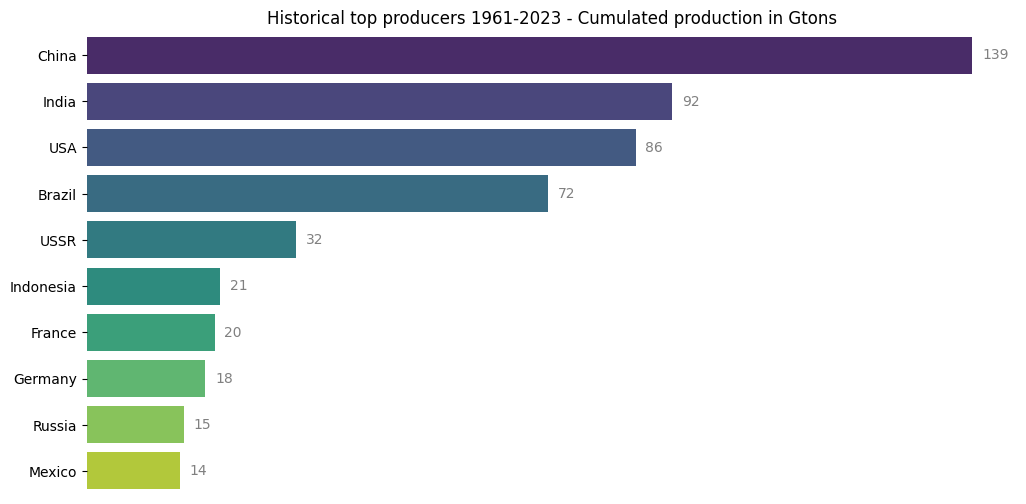

In [94]:
# --- Data prep ---
top_global_producers = get_top_producers(df_prod, period=[1961,2023], top_n=10)

# --- Plotting ---
plt.figure(figsize=(12,6))
# Custom labels for lisibility
custom_labels = ["China","India","USA","Brazil","USSR","Indonesia","France","Germany","Russia","Mexico"]
# Plotting barplot
ax = sns.barplot(x=top_global_producers["Value"], y=top_global_producers.index, palette="viridis")
# Setup of the plot
ax.set_yticks(ax.get_yticks(), labels=custom_labels)
ax.set_xticks([])
plt.title("Historical top producers 1961-2023 - Cumulated production in Gtons")
plt.xlabel(None)
plt.ylabel(None)
plt.grid(False)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.bar_label(ax.containers[0], fmt="%d", color="grey", padding=7) 
plt.show()

The global production is largely dominated by China (139 Gtons on the period), far away from India (92 Gtons) and the USA (86 Gtons). This underlines an Asian dynamic preponderance. USSR is still in Top10 in this period even if exploded in 1991. Russian Federation is also present as top 9, reflecting it maintained an important agricultural production.   
Other countries formed the end of this ranking, but it needs a tendency analysis to check if it is due to former or newer important production volumes. For instance, were Brazil and Indonesia always in top 10 or are they emerging countries ? What about France and Germany ?

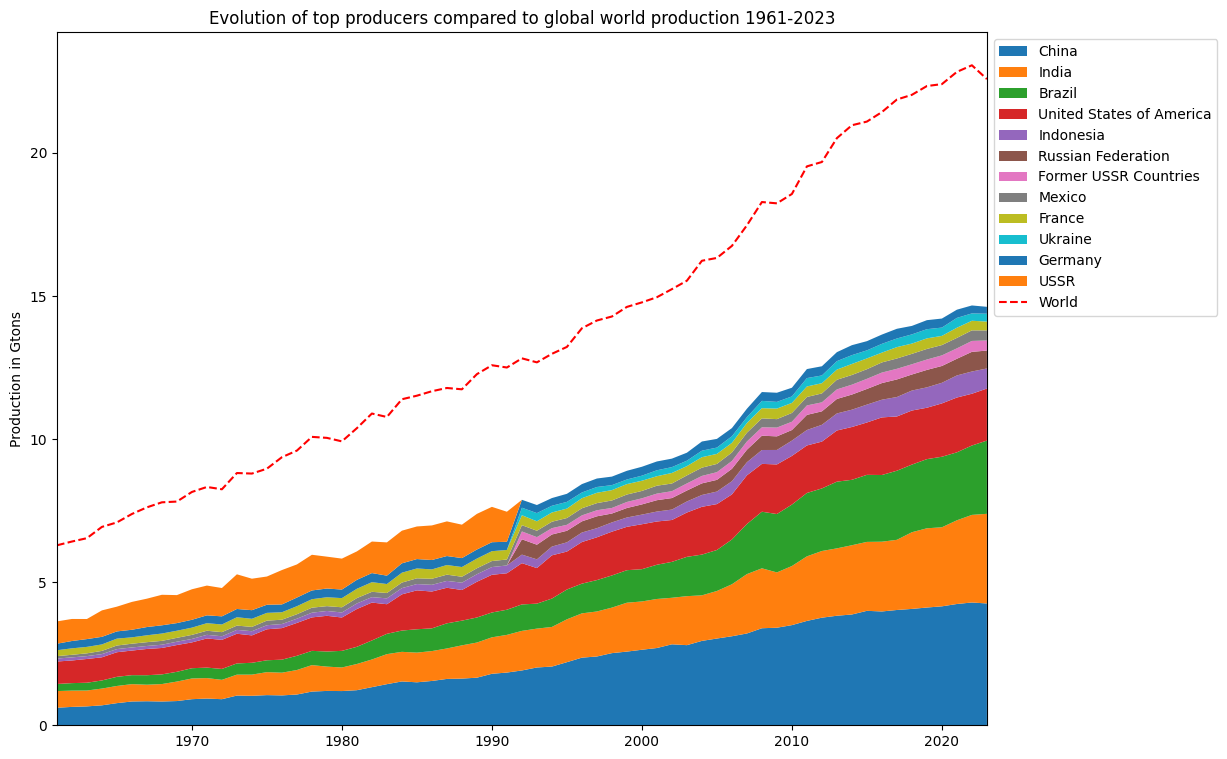

In [96]:
# --- Data prep ---
# Adding Fromer USSR Countries and Ukraine
top_historical_producers = np.append(top_global_producers.index, ["Former USSR Countries", "Ukraine"])
# Getting evolution of production from top historical producers
historical_production = get_historical_production(df_prod,
                                                      top_historical_producers,
                                                      period=[1961,2023],
                                                      product=None)
# Pivoting data and filling na as 0
top_historical_production = historical_production.pivot(index="Area",
                                                        columns="Year",
                                                        values="Value").fillna(0)
# Ordering last year with descending producers for better visibility
last_year_rank = top_historical_production[2023].sort_values(ascending=False).index
top_historical_production = top_historical_production.reindex(last_year_rank)

# --- Plotting ---
plt.figure(figsize=(12,9))
# Stacked areas for top producers
plt.stackplot(top_historical_production.columns,
             top_historical_production,
             labels=top_historical_production.index)
# Line for global production
sns.lineplot(data=global_prod, x="Year", y="Value", label="World", color="r", ls="--")
# Plot setup
plt.title("Evolution of top producers compared to global world production 1961-2023")
plt.legend(bbox_to_anchor=(1,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")
plt.show()

Key elements: 
- The top 10 agricultural countries ever from data records produces around 50% of the global production across the globe 
- China is, almost from the beginning, the biggest producer, and mainly drives the increase over the year. 
- India and Brazil are just behind China, and have known a boom in production in the late 2000s driving the boom globally
- United States production is still one of the most important, but have grown more slowly than the three first producers
- USSR was one of the biggest producers, and its explosion has lowered the production in 1992 but rapidly has been covered by production from Russia, Ukraine and other former USSR countries (all included in the plot to keep consistency between periods)
- Indonesia is involved in the Asian dynamics in the domination for agricultural production

# Evolution of top producers

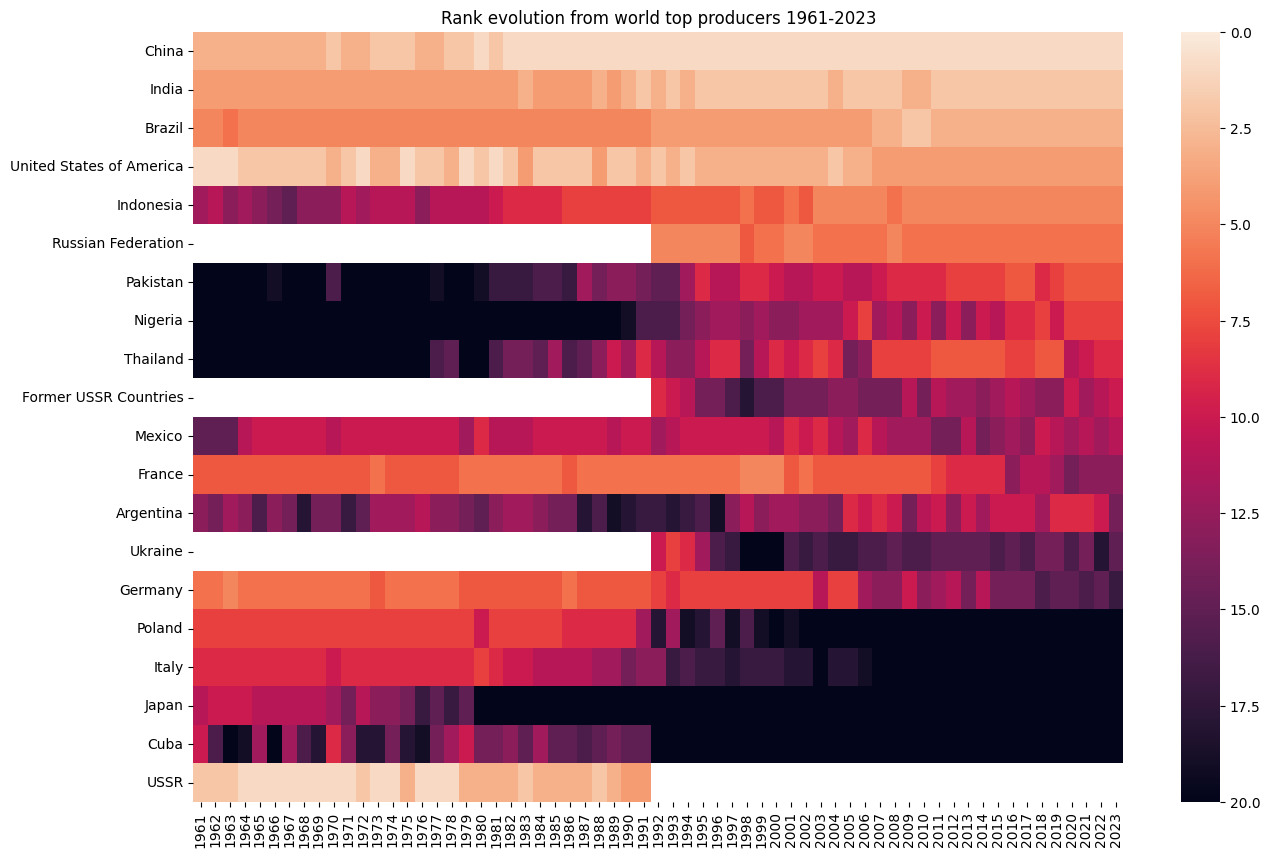

In [117]:
# --- Data prep ---
# Getting historical ranks
top_historical_ranks = get_historical_rank(df_prod, countries=None)
# Getting countries that has been at least one year in Top10
top_countries = top_historical_ranks[top_historical_ranks["Rank"]<=10]["Area"].unique()
# Filtering on top countries
top_historical_ranks = top_historical_ranks[top_historical_ranks["Area"].isin(top_countries)]
# Pivoting data 
pivot_ranks = top_historical_ranks.pivot(index="Area",columns="Year",values="Rank")
# Ordering countries on last year rank
last_year_rank = pivot_ranks[2023].sort_values().index
pivot_ranks = pivot_ranks.reindex(last_year_rank)

# --- Plotting ---
plt.figure(figsize=(15,10))
# Heatmap on rank evolution over time
ax = sns.heatmap(pivot_ranks, vmin=0, vmax=20, cmap="rocket_r")
# Plot setup
ax.set_title("Rank evolution from world top producers 1961-2023")
ax.set_ylabel(None)
ax.set_xlabel(None)
plt.gcf().axes[1].invert_yaxis()
plt.show()

The plot shows the rank evolution for each country that has been one year in the top 10 of global agricultural producers in the world. It shows several dynamics: 
- Some historical top producers have always been there and are still top : China, India, Brazil, USA, or even have gained rank : Indonesia
- Some historical top producers have slowly fade away from top10 and even top20 especially from the beginning of 1990s: Cuba, Japan, Italy or Poland
- Other historical were longer in top 10 but are slowly decreasing in ranking : France, Germany
- Letting aside their particularity, USSR, Russia and former USSR countries have always been among top producers
- Some new players have come into the competition and are exploding since 1980s (Thailand, Pakistan) or 1990s (Nigeria) and are participating in new emerging countries

**Key take-aways** : if the global production is still mainly dominated by a few countries (China, India, Brazil, USA, and to some extent Indonesia, and Russia and former USSR countries), new players are emerging in agricultural production (Pakistan, Nigeria, Thailand), surpassing old top producers that begin to lag behind (Germany, France, or more extensively Japan, Italy, Poland)

In [125]:
top_historical_production

,Area,Year,Value,Rank
359,Argentina,2005,0.300321,9
360,Argentina,2006,0.292817,10
361,Argentina,2007,0.320347,9
362,Argentina,2008,0.333049,10
365,Argentina,2011,0.341771,10
...,...,...,...,...
11043,United States of America,2019,1.795660,4
11044,United States of America,2020,1.863348,4
11045,United States of America,2021,1.915118,4
11046,United States of America,2022,1.808904,4


In [126]:
# --- Data prep ---
historical_production = get_historical_rank(df_prod)
top_historical_production = historical_production[historical_production["Rank"]<=10]\
                                .sort_values(by="Year")

# --- Plotting ---
fig = px.scatter_geo(
    top_historical_production,
    locations="Area",
    locationmode="country names",
    size="Value",
    color="Area",
    hover_name="Area",
    animation_frame="Year",
    projection="natural earth",
    title="Evolution of top 10 agricultural producers (1961–2023)",
    size_max=70
)

fig.show()

From this animation, we can clearly see: 
- An everlasting increase of the production from top producers
- In the 1960s, the production is mainly dominated by former top countries : US, USSR, Europe ; but emerging countries are already present : China, India, Brazil. 
- By the end of data records, we see a shift in world dyanmics, as agricultural production is mainly driven by Asian countries (China and India still in top, joined by Indonesia, Thailand, Pakistan) and supported by Brazil (#3) and Nigeria. Europe have downfallen from this top 10 : no country is longer in top 10

# Focus on winners

## China

In [128]:
china_prod

,Item,Year,Value
0,"Beef and Buffalo Meat, primary",1961,0.000079
1,"Beef and Buffalo Meat, primary",1962,0.000107
2,"Beef and Buffalo Meat, primary",1963,0.000135
3,"Beef and Buffalo Meat, primary",1964,0.000153
4,"Beef and Buffalo Meat, primary",1965,0.000168
...,...,...,...
1265,Vegetables Primary,2019,0.588748
1266,Vegetables Primary,2020,0.595526
1267,Vegetables Primary,2021,0.603102
1268,Vegetables Primary,2022,0.612979


In [135]:
# --- Data prep ---
china_prod = get_country_production_items(df_prod, "China")

# --- Plotting ---
px.line(data_frame=china_prod, 
       x="Year",
       y="Value",
       color="Item",
       title="Evolution of production in China",
       labels={"Year":"","Value":"Production in Gtons"})

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    <ul>
    <li>Main products that China is currently producing are Cereals and Vegetables, far away from other products : x3 compared to Fruit production, x4 compared to Roots, x6 compared to sugar crops or Meat</li>
    <li>Back in 1960s, the main products were Cereals (already), Roots and Vegetables</li>
    <li>Products that mainly driven the increase in the production are Cereals (x6 in 70 years) and Vegetables (x12)</li>
    </ul>
</div>

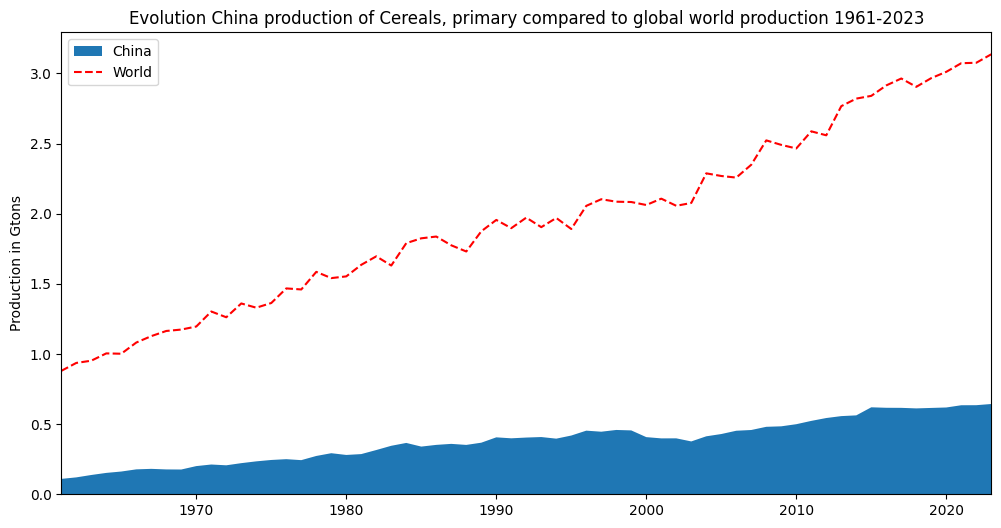


          Share of Cereals, primary production in 1961 compared to global: 12.47%
          Share of Cereals, primary production in 2023 compared to global: 20.52%
          


,Value
Area,
China,23.980177
United States of America,19.833014
India,12.618701
USSR,4.958993
Brazil,3.342634


In [200]:
get_report_country_on_item(df_prod,"China","Cereals, primary")

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    China production on Cereals have grown from 12% of global production to 20%. It is the biggest producer in 2023, followed by the US, India, Brazil and Russia
</div>

## India

In [197]:
# --- Data prep ---
india_prod = get_country_production_items(df_prod, "India")

# --- Plotting ---
px.line(data_frame=india_prod, 
       x="Year",
       y="Value",
       color="Item",
       title="Evolution of production in India",
       labels={"Year":"","Value":"Production in Gtons"})

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    India has based its increase in agricultural production on its historical products: Sugar Crops and Cereals. However, it slowly developed various other products to support its global production : Milk, Vegetables, Fruits, or even Roots
</div>

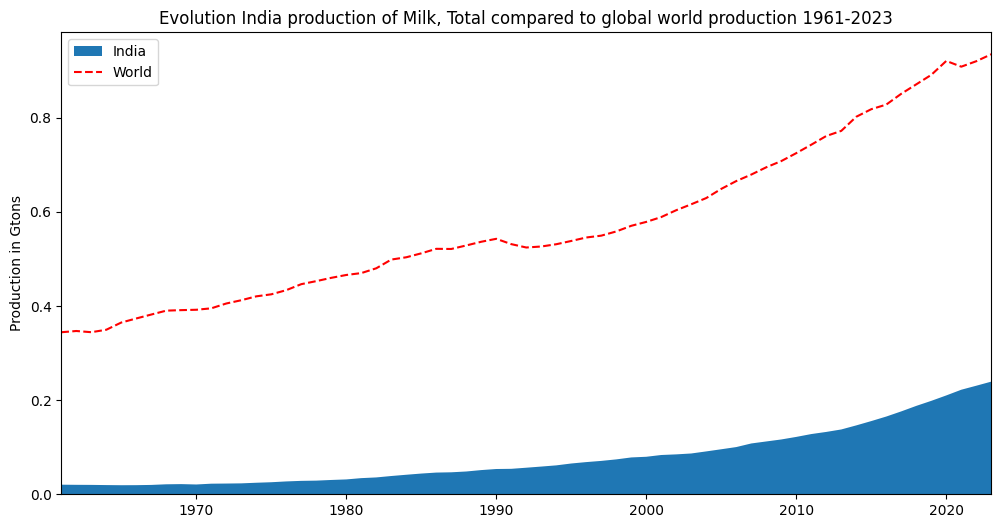


          Share of Milk, Total production in 1961 compared to global: 5.92%
          Share of Milk, Total production in 2023 compared to global: 25.6%
          


,Value
Area,
India,4.905050
United States of America,4.516279
USSR,2.730324
Germany,1.785419
France,1.555266


In [205]:
get_report_country_on_item(df_prod,"India","Milk, Total")

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    Milk production in India has exploded comparatively from the rest of the world, as from 6% of world production, it is now at 25% of the world production. India is the biggest producer of milk in the world, far from the US (x2.4 the production) Pakistan (x3.7), or China (x5)
</div>

## Brazil

In [202]:
# --- Data prep ---
brazil_prod = get_country_production_items(df_prod, "Brazil")

# --- Plotting ---
px.line(data_frame=brazil_prod, 
       x="Year",
       y="Value",
       color="Item",
       title="Evolution of production in Brazil",
       labels={"Year":"","Value":"Production in Gtons"})

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    Brazil boom in agricultural production is mainly and almost only due by its production on Sugar crops: from 0.06 Gtons in 1961 to a maximum of 0.78 Gtons in 2023, this represents a + 1200% increase !
</div>

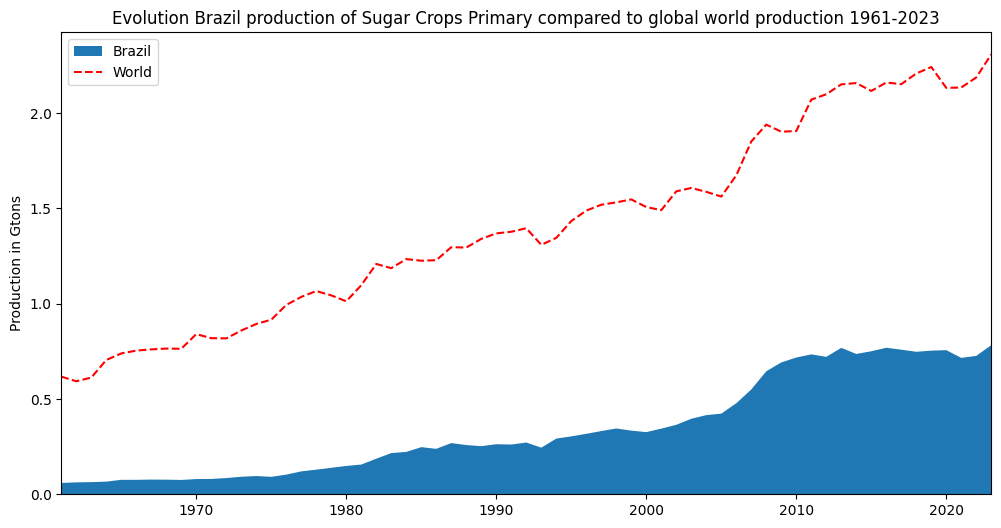


          Share of Sugar Crops Primary production in 1961 compared to global: 9.62%
          Share of Sugar Crops Primary production in 2023 compared to global: 33.9%
          


,Value
Area,
Brazil,21.874491
India,14.857423
China,4.644026
United States of America,3.303219
Thailand,2.819888


In [204]:
get_report_country_on_item(df_prod,"Brazil","Sugar Crops Primary")

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    Brazil production for Sugar Crops has exploded compared to other countries, and is one of the 2 leading countries over the Suger Crops production. It went from 9.6% of the global production in 1961 to more than 1/3 of the global prod in 2023. It is by far the biggest producer along with India (x1.6). Behind, we can find China (factor x7 less), Thailand (x8) or Pakistan (x9)

</div>

## Focus on USSR

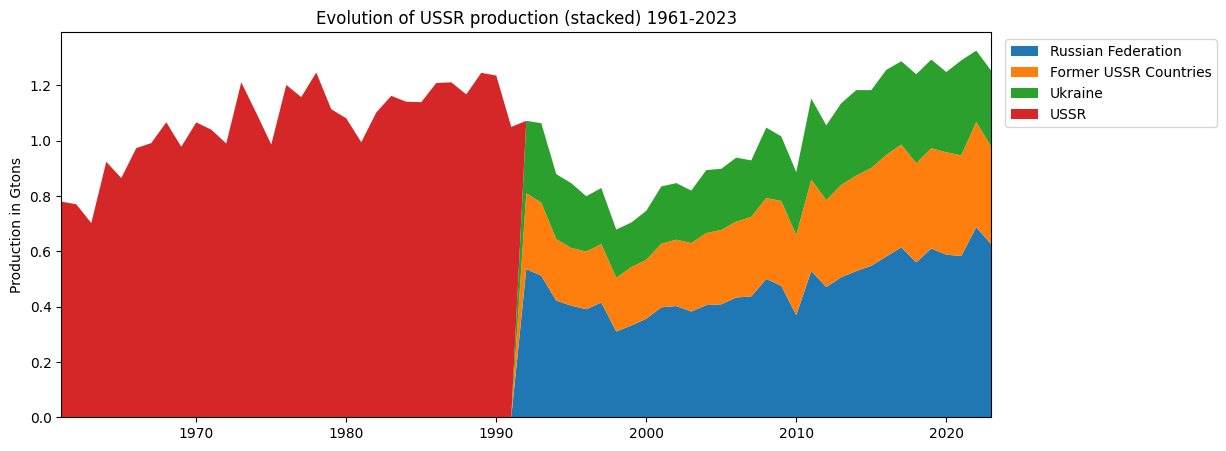

In [265]:
ussr_historical_prod = get_historical_production(df_prod, ["USSR","Former USSR Countries","Russian Federation","Ukraine"])

plt.figure(figsize=(12,5))

plt.stackplot(ussr_historical_prod.columns,
             ussr_historical_prod,
             labels=ussr_historical_prod.index)

plt.title("Evolution of USSR production (stacked) 1961-2023")
plt.legend(bbox_to_anchor=(1.25,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

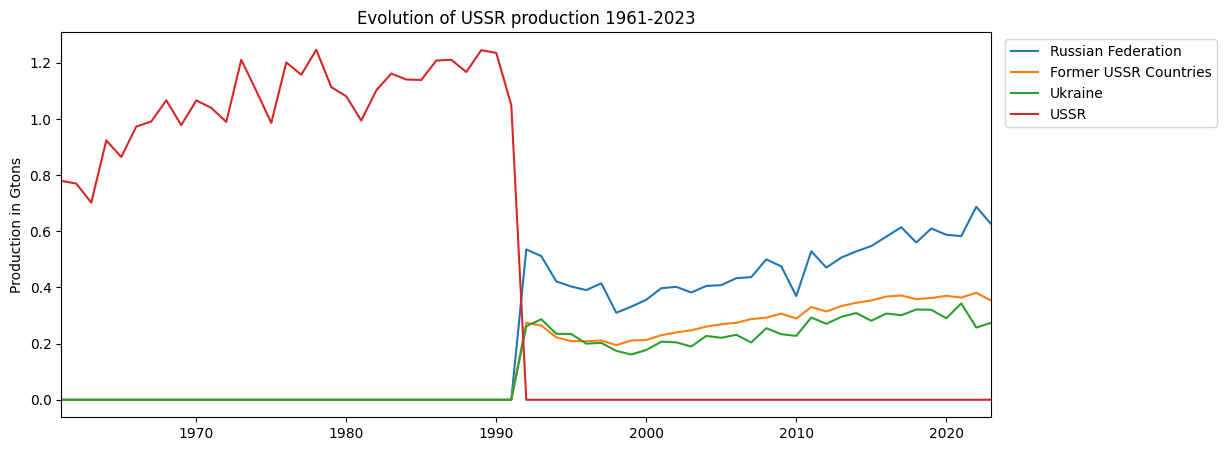

In [264]:
plt.figure(figsize=(12,5))

for country in ussr_historical_prod.index:
    plt.plot(ussr_historical_prod.loc[country,:], label=country)

plt.title("Evolution of USSR production 1961-2023")
plt.legend(bbox_to_anchor=(1.25,1))
plt.xlim([1961,2023])
plt.xlabel(None)
plt.ylabel("Production in Gtons")

plt.show()

<div style="
    background-color: #e6f2ff; 
    border: 1px solid #b3d1ff; 
    border-radius: 8px; 
    padding: 12px; 
    margin: 10px 0; 
    font-size: 14px;
">
    <b>Analysis 🔍</b> </br>
    When the USSR exploded and seperated into various countries, we can clearly see a fall in production, especially driven by the Russian Federation. After that, production levels are relatively stable, let alone for a new fall in production for Russia un 2010
</div>